# Библиотеки

In [1]:
import re
import os
import sys
import string
import shutil
import multiprocessing

import findspark
import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# PySpark контекст

Как установить PySpark на Windows - [Полный гид](https://www.machinelearningplus.com/pyspark/install-pyspark-on-windows/)

Добавим `PYSPARK_PYTHON` и `PYSPARK_DRIVER_PYTHON` в PATH. [Подробнее](https://stackoverflow.com/questions/48260412/environment-variables-pyspark-python-and-pyspark-driver-python):

In [4]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

Скачаем бинарники `hadoop.dll` и `winutils.exe` последних версий с [гитхаба](https://github.com/kontext-tech/winutils). Оба файла поместим в папку, укажем путь до неё в переменной среды `HADOOP_HOME`. Помимо этого, файл `hadoop.dll` поместим в папку `C:\Windows\System32`. Подробнее [здесь](https://stackoverflow.com/questions/41851066/exception-in-thread-main-java-lang-unsatisfiedlinkerror-org-apache-hadoop-io).

In [5]:
os.environ['HADOOP_HOME'] = "C:\\hadoop"

In [6]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')\
                  .set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')\
                  .set('spark.dynamicAllocation.enabled', 'true')\
                  .set('spark.shuffle.service.enabled', 'true') #трекер, чтобы возвращать ресурсы

sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()
display(spark)

In [7]:
print(f"JDK version: {os.popen('java --version').read()}")
print(f"Python version: {sys.version}")
print(f"Spark version: {pyspark.__version__}")
print(f"Hadoop version = {sc._jvm.org.apache.hadoop.util.VersionInfo.getVersion()}")

JDK version: java 22 2024-03-19
Java(TM) SE Runtime Environment (build 22+36-2370)
Java HotSpot(TM) 64-Bit Server VM (build 22+36-2370, mixed mode, sharing)

Python version: 3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]
Spark version: 3.5.1
Hadoop version = 3.3.4


# Lesson

## Create RDD & Num of partitions

Как проще всего создать RDD? Вызвать метод и передать ему нужный объект:

In [8]:
first_rdd  = sc.parallelize(range(1000000))

In [9]:
first_rdd.getNumPartitions()

8

А можно ли менять количество партиций? Да, для этого есть два метода: `repartition()` и `coalesce()`. Первый используется для увеличения и уменьшения количества партиций, второй только для снижения, причем `coalesce` будет работать эффективнее. Много партиций - дольше будет считаться, но если данных много, то обязательно нужно

`repartition()` всегда приводит к равномерному перераспределению данных, что ведет к shuffle. Если Вы уменьшаете число партиций, то стоит использовать `coalesce()`, который может избежать shuffle

In [10]:
first_rdd = first_rdd.repartition(5)
print(first_rdd.getNumPartitions())

5


In [11]:
first_rdd = first_rdd.repartition(2)
print(first_rdd.getNumPartitions())

2


In [12]:
first_rdd = first_rdd.coalesce(1)
print(first_rdd.getNumPartitions())

1


In [13]:
a = %time first_rdd.sum()

CPU times: total: 0 ns
Wall time: 9.5 s


Посмотрим на время выполнения для разного числа партиций

In [14]:
result = []
first_rdd  = sc.parallelize(range(5000000))
for partition in range(1, 5):
    first_rdd = first_rdd.repartition(partition)
    time = %timeit -o  -n 1 -r 1 first_rdd.sum()
    time = time.best
    result.append((partition, time))

9.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.82 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.95 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


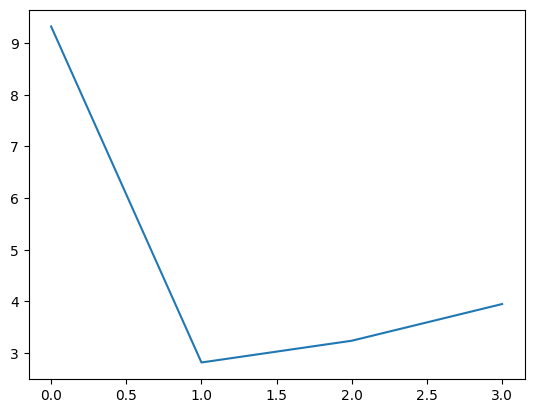

In [15]:
plt.plot([res[1] for res in result])
plt.show()

А почему лучший результат при небольшом количестве партиций?

In [16]:
multiprocessing.cpu_count()

8

Из list также можно создавать RDD

In [17]:
bad_list = [1, 2, 3, 'a', 10, 'b']

In [18]:
bad_list_rdd = sc.parallelize(bad_list)

In [19]:
bad_list_rdd.collect()

[1, 2, 3, 'a', 10, 'b']

Еще можно создать RDD через textFile и wholeTextFiles

In [20]:
text_rdd = sc.textFile('spark_text.txt')

In [21]:
text_rdd.take(1)

['Apache Spark is an open-source unified analytics engine for large-scale data processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. Originally developed at the University of California, Berkeley AMPLab, the Spark codebase was later donated to the Apache Software Foundation, which has maintained it since.']

wholeTextFiles создает PairRDD в формате key-value, где ключ - имя файла, а значения - то, что находистя в файле. Имена файлов считываются из папки через wholeTextFiles

In [22]:
dirPath = Path('files')
dirPath.mkdir(exist_ok=True)

with open(dirPath / "1.txt", "w") as file1:
    _ = file1.write("[1 2 3]")
    
with open(dirPath / "2.txt", "w") as file2:
    _ = file2.write("[4 5 6]")

textFiles = sc.wholeTextFiles(str(dirPath))

In [23]:
textFiles

org.apache.spark.api.java.JavaPairRDD@44d86ded

In [24]:
textFiles.collect()

[('file:/C:/Users/Admin/Desktop/pyspark/lesson_2/files/1.txt', '[1 2 3]'),
 ('file:/C:/Users/Admin/Desktop/pyspark/lesson_2/files/2.txt', '[4 5 6]')]

У RDD есть стандартно 2 типа методов - actions и transformations

## Actions

Начнем с actions, то есть того, что заставит посчитать

In [25]:
first_rdd = first_rdd.coalesce(2)

In [26]:
first_rdd.sum()

12499997500000

In [27]:
first_rdd.min(), first_rdd.max()

(0, 4999999)

In [28]:
first_rdd.first()

190

In [29]:
first_rdd.take(2)

[190, 191]

In [30]:
first_rdd.count()

5000000

In [31]:
a = first_rdd.collect()

In [32]:
first_rdd.saveAsTextFile, first_rdd.saveAsPickleFile

(<bound method RDD.saveAsTextFile of CoalescedRDD[40] at coalesce at DirectMethodHandleAccessor.java:103>,
 <bound method RDD.saveAsPickleFile of CoalescedRDD[40] at coalesce at DirectMethodHandleAccessor.java:103>)

In [33]:
first_rdd.reduce(lambda x, y: x + y)

12499997500000

Если нужно получить небольшое число записей на драйвер и, при этом, сохранить распределение, то лучше сделать выборку

In [34]:
first_rdd.takeSample(withReplacement=False, num=5, seed=5757)

[4357022, 2400100, 4590395, 1691486, 1120509]

## Transformations

Это просто трансформации, которые не будут вычисляться до вызова actions

In [35]:
a = sc.parallelize([1, 2, 3])
b = sc.parallelize([2, 3, 4])

In [36]:
c = a + b

In [37]:
c.collect()

[1, 2, 3, 2, 3, 4]

### filter

In [38]:
text_rdd.count()

100

In [39]:
text_rdd.filter(lambda x: x != '').count()

60

In [40]:
text_rdd = text_rdd.filter(lambda x: x != '')

### map

In [41]:
stop_words = stopwords.words("english")
stop_words = set(stop_words)

In [42]:
def mapper_text(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words_with_value = [(word.lower(), 1) for word in words 
                        if word not in stop_words]
    return words_with_value

In [43]:
text_rdd.map(mapper_text).take(1)

[[('apache', 1),
  ('spark', 1),
  ('opensource', 1),
  ('unified', 1),
  ('analytics', 1),
  ('engine', 1),
  ('largescale', 1),
  ('data', 1),
  ('processing', 1),
  ('spark', 1),
  ('provides', 1),
  ('interface', 1),
  ('programming', 1),
  ('entire', 1),
  ('clusters', 1),
  ('implicit', 1),
  ('data', 1),
  ('parallelism', 1),
  ('fault', 1),
  ('tolerance', 1),
  ('originally', 1),
  ('developed', 1),
  ('university', 1),
  ('california', 1),
  ('berkeley', 1),
  ('amplab', 1),
  ('spark', 1),
  ('codebase', 1),
  ('later', 1),
  ('donated', 1),
  ('apache', 1),
  ('software', 1),
  ('foundation', 1),
  ('maintained', 1),
  ('since', 1)]]

### flatMap

Попробуем применить map и flatMap

In [44]:
text_rdd.map(mapper_text).count()

60

In [45]:
text_rdd.flatMap(mapper_text).count()

1921

Как так?

In [46]:
text_rdd.map(mapper_text).map(len).sum()

1921

вроде понятно что случилось, но давайте на игрушечном примере

In [47]:
simple_example = sc.parallelize([[1, 2, 3], [2, 3, 4], [4, 5, 6]])

In [48]:
def pow_elements(elements):
    return [x**2 for x in elements]

In [49]:
simple_example.map(pow_elements).collect()

[[1, 4, 9], [4, 9, 16], [16, 25, 36]]

In [50]:
simple_example.flatMap(pow_elements).collect()

[1, 4, 9, 4, 9, 16, 16, 25, 36]

### groupByKey

In [51]:
text_rdd = text_rdd.flatMap(mapper_text)

In [52]:
text_rdd.groupByKey().mapValues(len).collect()

[('apache', 56),
 ('opensource', 1),
 ('analytics', 5),
 ('largescale', 1),
 ('interface', 10),
 ('entire', 1),
 ('implicit', 1),
 ('fault', 1),
 ('tolerance', 1),
 ('codebase', 1),
 ('donated', 2),
 ('resilient', 2),
 ('distributed', 23),
 ('dataset', 7),
 ('rdd', 15),
 ('multiset', 1),
 ('machines', 1),
 ('faulttolerant', 1),
 ('way2', 1),
 ('dataframe', 3),
 ('api', 14),
 ('released', 1),
 ('1x', 1),
 ('primary', 1),
 ('use', 9),
 ('even', 5),
 ('though', 1),
 ('deprecated45', 1),
 ('technology', 2),
 ('still', 2),
 ('api67', 1),
 ('response', 2),
 ('limitations', 1),
 ('computing', 5),
 ('paradigm', 2),
 ('forces', 1),
 ('structure', 3),
 ('read', 1),
 ('input', 2),
 ('disk', 3),
 ('map', 6),
 ('results', 2),
 ('working', 1),
 ('set', 5),
 ('form', 2),
 ('shared', 2),
 ('memory8', 1),
 ('iterative', 2),
 ('algorithm', 1),
 ('ms', 1),
 ('multiple', 4),
 ('times', 4),
 ('interactiveexploratory', 1),
 ('analysis', 2),
 ('ie', 1),
 ('repeated', 1),
 ('databasestyle', 1),
 ('application

### sortByKey

In [53]:
text_rdd.groupByKey().mapValues(len).sortByKey().collect()

[('10', 1),
 ('11', 1),
 ('16', 1),
 ('1ms', 1),
 ('1x', 1),
 ('20', 1),
 ('2009', 1),
 ('2012', 1),
 ('23', 1),
 ('24', 1),
 ('2x', 3),
 ('50', 1),
 ('5g', 1),
 ('a', 4),
 ('able', 1),
 ('abstraction', 6),
 ('abstracts', 1),
 ('according', 1),
 ('accumulators', 1),
 ('achieved', 1),
 ('across', 5),
 ('acyclic', 1),
 ('added', 2),
 ('addition', 1),
 ('additional', 1),
 ('advantage', 4),
 ('advantages', 1),
 ('afforded', 1),
 ('aggregation', 1),
 ('aggregations', 1),
 ('algorithm', 1),
 ('algorithms', 7),
 ('all', 1),
 ('allocating', 1),
 ('allowing', 3),
 ('allows', 2),
 ('alluxio', 1),
 ('almost', 1),
 ('alone', 1),
 ('alongside', 1),
 ('als', 1),
 ('also', 15),
 ('alternating', 1),
 ('although', 1),
 ('amazon', 3),
 ('among', 2),
 ('amplab', 3),
 ('analysis', 2),
 ('analysts', 1),
 ('analytics', 5),
 ('anonymous', 1),
 ('apache', 56),
 ('apex', 1),
 ('api', 14),
 ('api27', 1),
 ('api67', 1),
 ('apis', 3),
 ('apple', 1),
 ('application', 8),
 ('applications', 5),
 ('applied', 1),
 ('a

И так на самом деле много методов, но предалагаю написать подсчет частоты слов и сделаем это в стиле программ на java

In [54]:
text_rdd = sc.textFile('spark_text.txt')

In [55]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text)\
                 .groupByKey()\
                 .mapValues(len)\
                 .sortBy(lambda x: x[1], ascending=False)\
                 .collect()

In [56]:
result[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('rdd', 15),
 ('learning', 15),
 ('also', 15)]

### reduceByKey

Забыли про reduceByKey

In [57]:
text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .reduceByKey(lambda x, y: x + y)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('rdd', 15),
 ('learning', 15),
 ('also', 15)]

Стоит заметить, что `groupByKey()` предполагает перемещение всех записей с одним ключом на один экзекьютор. В случае очень скошенных распределений это может привести к падению экзекьютора с OOM. Поэтому всегда при группировках стоит подумать об использовании `reduceByKey()`.

Так, на лекции было что-то про count, который не делает shuffle да и вообще можно проще написать?

In [58]:
def mapper_text_simple(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words = [word.lower() for word in words 
                        if word not in stop_words]
    return words

In [59]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text_simple)\
                 .countByValue()
result = sorted(result.items(), key=lambda x: x[1], reverse=True)
print(result[:10])

[('spark', 110), ('apache', 56), ('data', 44), ('streaming', 36), ('distributed', 23), ('processing', 19), ('sql', 17), ('rdd', 15), ('learning', 15), ('also', 15)]


Замеры

In [60]:
%%timeit

text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .groupByKey()\
        .mapValues(len)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

9.08 s ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%%timeit

text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .reduceByKey(lambda x, y: x + y)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

9.08 s ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%%timeit

result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text_simple)\
                 .countByValue()
result = sorted(result.items(), key=lambda x: x[1], reverse=True)[:10]

2.07 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Joins

Тут просто на игрушечном примере пощупаем данную операцию

In [63]:
rdd_a = sc.parallelize([
                        ('a', [1, 2]),
                        ('b', [2, 4])])

rdd_b = sc.parallelize([
                        ('a', [10]),
                        ('c', [11])])

In [64]:
rdd_a.join(rdd_b).collect()

[('a', ([1, 2], [10]))]

In [65]:
rdd_a.leftOuterJoin(rdd_b).collect()

[('a', ([1, 2], [10])), ('b', ([2, 4], None))]

In [66]:
rdd_a.fullOuterJoin(rdd_b).collect()

[('c', (None, [11])), ('a', ([1, 2], [10])), ('b', ([2, 4], None))]

# Homework 1

Посчитать количество рейтингов больше 4 для каждого фильма и вывести фильмы в порядке убывания количества этих оценок (можно вывести топ 10)

Файл можете взять из прошлого домашнего задания + сохраните результат на диск

In [67]:
def read_ratings(path):
    with open(path, 'rb') as f:
        data = f.readlines()
    headers = data[0].decode().split('\t')[:3]
    data = [row.decode().split('\t')[:3] for row in data[1:]]
    return headers, data

def create_batches(data, batch_size):
    batches = [data[i:i+batch_size] for i in range(0, len(data), batch_size)]
    return batches

def map_rating(rows, movie_idx=1, rating_idx=2):
    rows_with_value = [
        (row[movie_idx], 1)
        for row in rows
        if float(row[rating_idx]) >= 4
    ]
    return sorted(rows_with_value, key=lambda x:x[0])

In [68]:
headers, data = read_ratings('../lesson_1/user_ratedmovies.dat')

BATCH_SIZE = 8
ratings_rdd = sc.parallelize(create_batches(data, BATCH_SIZE))

ratings_rdd.take(1)

[[['75', '3', '1'],
  ['75', '32', '4.5'],
  ['75', '110', '4'],
  ['75', '160', '2'],
  ['75', '163', '4'],
  ['75', '165', '4.5'],
  ['75', '173', '3.5'],
  ['75', '296', '5']]]

In [69]:
ratings_rdd = ratings_rdd.flatMap(map_rating)\
                         .reduceByKey(lambda x, y: x + y)\
                         .sortBy(lambda x: x[1], ascending=False)\
                         .persist()

In [70]:
ratings_rdd.collect()[:10]

[('2571', 1300),
 ('296', 1249),
 ('318', 1227),
 ('4993', 1168),
 ('2959', 1145),
 ('2858', 1099),
 ('5952', 1097),
 ('7153', 1085),
 ('593', 1061),
 ('356', 1054)]

In [71]:
shutil.rmtree('./movie_ratings', ignore_errors=True)
ratings_rdd.saveAsPickleFile("./movie_ratings", batchSize=BATCH_SIZE)

# Homework 2

В этом задании у вас есть файл с обученным word2vec на произведении Достоевского Преступление и наказание. Файл - list, каждый элемент которого слово и его вектор в формате ('word', [vector]). Необходимо для каждого слова собрать список его top 10 похожих слов по косинусной метрике.

Результат также сохраните на диск и выведите синонимы для слова 'топор' и 'деньга'.
Файл в пикле, так что для считывания воспользуйтесь не spark, можете взять любимый pandas

Файл не очень уж и маленький, рекомендую сначала написать код на кошках/собачках, а потом уже на всем, так как ядра 2, считаться будет очень долго.
В качестве одного из вариантов можете рассмотреть метод cartesian

In [72]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def cosine_similarity_mapper(pair):
    return pair[0][0], (pair[1][0], cosine_similarity(pair[0][1], pair[1][1]))

def top_words_mapper(group, n_top=10):
    return sorted(group, key=lambda group: -group[1])[:n_top]

In [73]:
data = pd.read_pickle('w2v_vectors.pickle')

In [74]:
len(data)

4768

## Немножко слов

In [75]:
words = sc.parallelize(data[:5])

In [76]:
%%time
words.cartesian(words)\
     .map(cosine_similarity_mapper)\
     .groupByKey()\
     .mapValues(top_words_mapper)\
     .collect()

CPU times: total: 31.2 ms
Wall time: 1min 45s


[('всё',
  [('всё', 0.99999994),
   ('это', 0.8356289),
   ('знать', 0.64060575),
   ('раскольник', 0.29965016),
   ('свой', 0.13343307)]),
 ('свой',
  [('свой', 1.0),
   ('это', 0.18249348),
   ('знать', 0.17251503),
   ('всё', 0.13343307),
   ('раскольник', -0.036889892)]),
 ('знать',
  [('знать', 0.99999994),
   ('это', 0.7414977),
   ('всё', 0.64060575),
   ('раскольник', 0.17358038),
   ('свой', 0.17251503)]),
 ('это',
  [('это', 1.0),
   ('всё', 0.8356289),
   ('знать', 0.7414977),
   ('раскольник', 0.42143586),
   ('свой', 0.18249348)]),
 ('раскольник',
  [('раскольник', 0.99999994),
   ('это', 0.42143586),
   ('всё', 0.29965016),
   ('знать', 0.17358038),
   ('свой', -0.036889892)])]

## Все слова

In [77]:
words = sc.parallelize(data)

In [78]:
%%time
shutil.rmtree('./simular_words', ignore_errors=True)
words.cartesian(words)\
     .map(cosine_similarity_mapper)\
     .groupByKey()\
     .mapValues(top_words_mapper)\
     .saveAsPickleFile("./simular_words", batchSize=BATCH_SIZE)

CPU times: total: 93.8 ms
Wall time: 4min 4s


## Синонимы для слов

In [79]:
simular_words = sc.pickleFile('./simular_words')

In [80]:
%%time
words_to_find = ["топор", "деньга"]
simular_words.filter(lambda x: x[0] in words_to_find)\
             .collect()

CPU times: total: 0 ns
Wall time: 52.7 s


[('деньга',
  [('деньга', 1.0),
   ('вещь', 0.9063148),
   ('отдать', 0.8706483),
   ('убить', 0.842027),
   ('значит', 0.83862835),
   ('известно', 0.8266707),
   ('отец', 0.81461805),
   ('получить', 0.8137906),
   ('ограбить', 0.8044243),
   ('копейка', 0.8012078)]),
 ('топор',
  [('топор', 1.0),
   ('левый', 0.92365247),
   ('старуха', 0.922432),
   ('колено', 0.920666),
   ('побежать', 0.9120595),
   ('ломать', 0.91023904),
   ('бросить', 0.90634286),
   ('схватить', 0.902411),
   ('обнять', 0.89990807),
   ('бить', 0.89854604)])]

In [81]:
sc.stop()

In [82]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}